## Семинар 2 "Распознавание рукописных цифр"

ФИО: Петряйкин Федор Алексеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [17]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from scipy.stats import multivariate_normal
import sys
import layers
from layers import NeuralNetwork
%matplotlib inline

In [18]:
import imp
import layers

In [19]:
np.random.seed(7)

In [20]:
imp.reload(layers)

<module 'layers' from 'F:\\programming\\teaching\\2019_tehnotrack\\homeworks\\hw01\\task\\layers.py'>

In [21]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

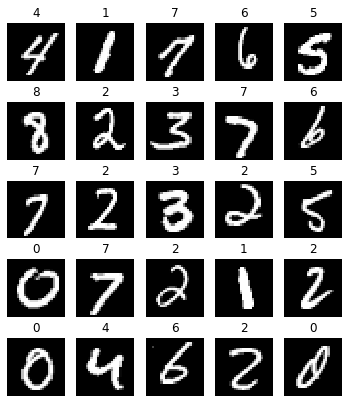

In [9]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [10]:
def blur_X(X, blur, rad, central):
    b_coeff = blur*np.random.random()
    weights = multivariate_normal([0, 0], [[b_coeff, 0], [0, b_coeff]])
    distr = np.zeros((rad*2, rad*2))
    for i in range(-rad, rad):
        for j in range(-rad, rad):
            distr[i+rad, j+rad] = weights.pdf([i, j])
                            
    for i in range(int(X.shape[0]/2.0)-central, int(X.shape[0]/2.0)+central):
        for j in range(int(X.shape[1]/2.0)-central, int(X.shape[1]/2.0)+central):
            X[i, j] = np.mean(X[i-rad:i+rad, j-rad:j+rad]*distr)

In [22]:
def train(network, epochs, learning_rate, verbose=False, train=train_loader, test=test_loader,
          blur=None, rad=2, central=10, blur_test=False):
    network.clear()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            
            verbose_current = True #One grads for epoch
            for X, y in train:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                
                #blur
                if not blur is None:
                    blur_X(X, blur, rad, central)
                
                prediction = network.forward(X, verbose and verbose_current)
                loss_batch = network.getloss(y)
                losses.append(loss_batch)
                
                #пустая строка между forward и backward в выдаче
                if verbose and verbose_current:
                    print("")
                
                network.backward(y, verbose and verbose_current)
                verbose_current = False
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1) == y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            losses = []
            accuracies = []    
            for X, y in test:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                
                #blur
                if blur_test and (not blur is None):
                    blur_X(X, blur, rad, central)
                
                prediction = network.forward(X)
                loss_batch = network.getloss(y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1) == y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            sys.stdout.write('\nEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}\n'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    finally:
        sys.stdout.write('\nBest for test: {0}'.format(max(test_accuracy_epochs)))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [12]:
imp.reload(layers)

<module 'layers' from 'F:\\programming\\teaching\\2019_tehnotrack\\homeworks\\hw01\\task\\layers.py'>

#### Обучение с различными нелинейностями

*3 линейных слоя, сигмоиды, SoftMax*

Для понимания динамики обучения, будем печатать dLdy и коэффициенты в каждой эпохе

In [13]:
network_sigmioid = NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                  layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.99e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.99e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.Sigmoid'> , coeff: No coeff
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.01e-03; W_std = 9.86e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.62e-03 ; std: 9.38e-03
4 <class 'layers.Linear'> , mean (abs) grad: 2.40e-04 ; std: 2.99e-04
3 <class 'layers.Sigmoid'> , mean (abs) grad: 5.99e-05 ; std: 7.46e-05
2 <class 'layers.Linear'> , mean (abs) grad: 6.16e-06 ; std: 7.75e-06
1 <class 'layers.Sigmoid'> , mean (abs) grad: 1.51e-06 ; std: 1.90e-06
0 <class 'layers.Linear'> , mean (abs) grad: 1.50e-07 ; std: 1.89e-07

Epoch 0... (Train/Test) NLL: 2.302/2.301	Accuracy: 0.111/0.11

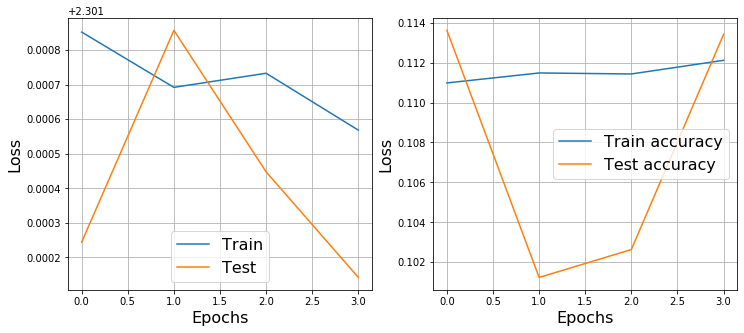

In [16]:
train(network_sigmioid, 20, 0.1, True)

* Нормально обучающаяся нейронная сеть. Нет больших коэффициентов в начальных слоях (отрыва от данных). Коэффициенты в первых слоях мало изменяются - некоторое затухание, сигмоида остается вблизи 0.

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

ELU


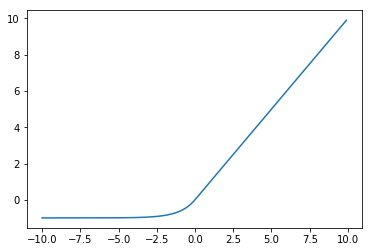

In [196]:
elu_layer = layers.ELU()
x = np.arange(-10, 10, 0.1)
y = elu_layer.forward(x)
print("ELU")
plt.plot(x, y)

ReLU


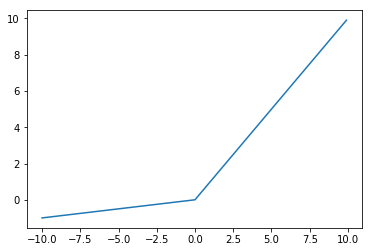

In [197]:
relu_layer = layers.ReLU()
y = relu_layer.forward(x)
print("ReLU")
plt.plot(x, y)

*3 линейных слоя, ELU (с изменяющимся параметром), SoftMax*

In [23]:
network_elu_notfixed = NeuralNetwork([layers.Linear(784, 100), layers.ELU(), layers.Linear(100, 100), 
                                      layers.ELU(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.98e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.ELU'> , coeff: 1.00e+00
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.94e-03; W_std = 9.97e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.ELU'> , coeff: 1.00e+00
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.25e-03; W_std = 1.03e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.63e-03 ; std: 9.38e-03
4 <class 'layers.Linear'> , mean (abs) grad: 2.42e-04 ; std: 3.04e-04
3 <class 'layers.ELU'> , mean (abs) grad: 2.42e-04 ; std: 3.04e-04
2 <class 'layers.Linear'> , mean (abs) grad: 2.38e-05 ; std: 2.99e-05
1 <class 'layers.ELU'> , mean (abs) grad: 2.38e-05 ; std: 2.99e-05
0 <class 'layers.Linear'> , mean (abs) grad: 2.40e-06 ; std: 3.02e-06

Epoch 0... (Train/Test) NLL: 0.557/0.278	Accuracy: 0.827/0.915
0 <class 'laye


Epoch 8... (Train/Test) NLL: 0.047/0.094	Accuracy: 0.985/0.973
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.94e-02; W_std = 4.19e-02 | b_mean (abs) = 2.23e-02; b_std = 2.08e-02
1 <class 'layers.ELU'> , coeff: 4.76e-02
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 5.20e-02; W_std = 6.78e-02 | b_mean (abs) = 2.98e-02; b_std = 3.70e-02
3 <class 'layers.ELU'> , coeff: 2.92e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.49e-01; W_std = 1.92e-01 | b_mean (abs) = 1.02e-01; b_std = 1.35e-01
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 2.26e-04 ; std: 1.38e-03
4 <class 'layers.Linear'> , mean (abs) grad: 2.17e-04 ; std: 8.49e-04
3 <class 'layers.ELU'> , mean (abs) grad: 1.54e-04 ; std: 7.21e-04
2 <class 'layers.Linear'> , mean (abs) grad: 3.87e-04 ; std: 1.55e-03
1 <class 'layers.ELU'> , mean (abs) grad: 8.48e-05 ; std: 5.43e-04
0 <class 'layers.Linear'> , mean (abs) grad: 8.78e-05 ; std: 3.26e-04

Epoch 9... (T


Epoch 17... (Train/Test) NLL: 0.010/0.112	Accuracy: 0.997/0.976
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.39e-02; W_std = 4.92e-02 | b_mean (abs) = 2.11e-02; b_std = 2.03e-02
1 <class 'layers.ELU'> , coeff: -3.74e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 6.22e-02; W_std = 8.07e-02 | b_mean (abs) = 5.95e-02; b_std = 7.68e-02
3 <class 'layers.ELU'> , coeff: 1.24e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.71e-01; W_std = 2.22e-01 | b_mean (abs) = 1.24e-01; b_std = 1.66e-01
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 2.23e-06 ; std: 1.88e-05
4 <class 'layers.Linear'> , mean (abs) grad: 2.62e-06 ; std: 1.32e-05
3 <class 'layers.ELU'> , mean (abs) grad: 1.97e-06 ; std: 1.19e-05
2 <class 'layers.Linear'> , mean (abs) grad: 6.24e-06 ; std: 3.04e-05
1 <class 'layers.ELU'> , mean (abs) grad: 3.62e-06 ; std: 2.06e-05
0 <class 'layers.Linear'> , mean (abs) grad: 2.01e-06 ; std: 1.22e-05

Epoch 18...

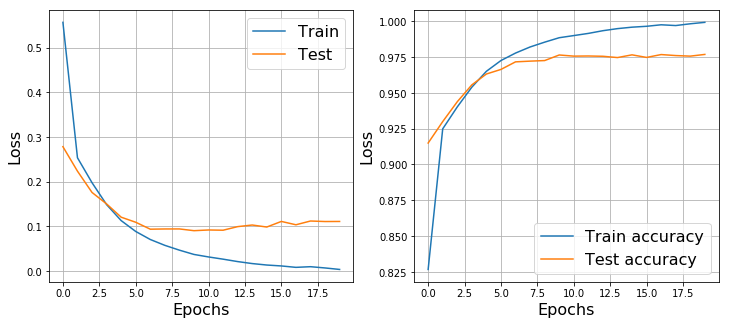

In [199]:
train(network_elu_notfixed, 20, 0.05, True) #С 0.1 учить нельзя - градиент elu очень быстро начинает "скакать" вокруг минимума

* Аналогично сети на сигмоидах, чуть лучше качество, но немного медленнее обучается

*3 линейных слоя, ELU (с фиксированным параметром), SoftMax*

In [200]:
network_elu_fixed = NeuralNetwork([layers.Linear(784, 100), layers.ELU(alpha0=0.1, fixed=True), layers.Linear(100, 100), 
                                   layers.ELU(alpha0=0.1, fixed=True), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.99e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.ELU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.94e-03; W_std = 9.93e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.ELU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.87e-03; W_std = 9.92e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.62e-03 ; std: 9.37e-03
4 <class 'layers.Linear'> , mean (abs) grad: 2.35e-04 ; std: 2.96e-04
3 <class 'layers.ELU'> , mean (abs) grad: 1.31e-04 ; std: 2.13e-04
2 <class 'layers.Linear'> , mean (abs) grad: 1.69e-05 ; std: 2.14e-05
1 <class 'layers.ELU'> , mean (abs) grad: 8.63e-06 ; std: 1.47e-05
0 <class 'layers.Linear'> , mean (abs) grad: 1.17e-06 ; std: 1.48e-06

Epoch 0... (Train/Test) NLL: 0.632/0.181	Accuracy: 0.790/0.945
0 <class 'laye


Epoch 8... (Train/Test) NLL: 0.025/0.083	Accuracy: 0.992/0.976
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.36e-02; W_std = 3.58e-02 | b_mean (abs) = 1.08e-02; b_std = 1.32e-02
1 <class 'layers.ELU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.78e-02; W_std = 6.60e-02 | b_mean (abs) = 2.67e-02; b_std = 2.87e-02
3 <class 'layers.ELU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.45e-01; W_std = 1.92e-01 | b_mean (abs) = 6.55e-02; b_std = 7.52e-02
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 1.14e-05 ; std: 7.68e-05
4 <class 'layers.Linear'> , mean (abs) grad: 1.03e-05 ; std: 4.76e-05
3 <class 'layers.ELU'> , mean (abs) grad: 7.73e-06 ; std: 4.08e-05
2 <class 'layers.Linear'> , mean (abs) grad: 1.89e-05 ; std: 8.09e-05
1 <class 'layers.ELU'> , mean (abs) grad: 7.52e-06 ; std: 4.46e-05
0 <class 'layers.Linear'> , mean (abs) grad: 4.51e-06 ; std: 2.09e-05

Epoch 9... (T


Epoch 17... (Train/Test) NLL: 0.001/0.089	Accuracy: 1.000/0.980
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.70e-02; W_std = 4.11e-02 | b_mean (abs) = 1.21e-02; b_std = 1.46e-02
1 <class 'layers.ELU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 5.61e-02; W_std = 7.69e-02 | b_mean (abs) = 3.17e-02; b_std = 3.45e-02
3 <class 'layers.ELU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.68e-01; W_std = 2.22e-01 | b_mean (abs) = 6.51e-02; b_std = 7.67e-02
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.99e-06 ; std: 3.76e-05
4 <class 'layers.Linear'> , mean (abs) grad: 6.88e-06 ; std: 2.67e-05
3 <class 'layers.ELU'> , mean (abs) grad: 5.11e-06 ; std: 2.26e-05
2 <class 'layers.Linear'> , mean (abs) grad: 1.55e-05 ; std: 5.49e-05
1 <class 'layers.ELU'> , mean (abs) grad: 7.30e-06 ; std: 3.66e-05
0 <class 'layers.Linear'> , mean (abs) grad: 4.92e-06 ; std: 2.20e-05

Epoch 18... 

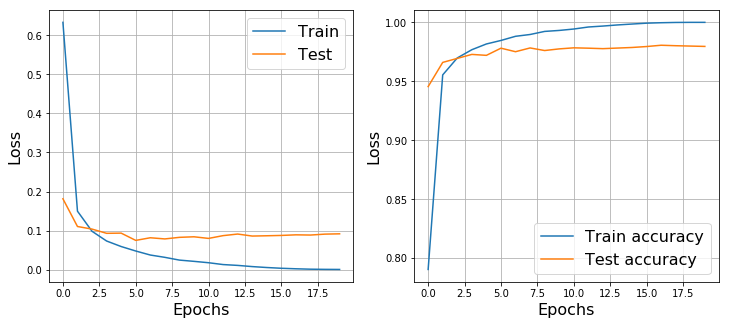

In [201]:
train(network_elu_fixed, 20, 0.05, True)

* Быстро обучается, хорошее качество

*3 линейных слоя, ReLU (с фиксированным параметром), SoftMax*

In [24]:
#Коэффициент в ReLU лучше не обучать - очень плохо сходится
network_relu_fixed = NeuralNetwork([layers.Linear(784, 100), layers.ReLU(fixed=True), layers.Linear(100, 100), 
                                    layers.ReLU(fixed=True), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.99e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.94e-03; W_std = 9.93e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.87e-03; W_std = 9.92e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.63e-03 ; std: 9.38e-03
4 <class 'layers.Linear'> , mean (abs) grad: 2.33e-04 ; std: 2.97e-04
3 <class 'layers.ReLU'> , mean (abs) grad: 1.25e-04 ; std: 2.07e-04
2 <class 'layers.Linear'> , mean (abs) grad: 1.68e-05 ; std: 2.10e-05
1 <class 'layers.ReLU'> , mean (abs) grad: 8.30e-06 ; std: 1.42e-05
0 <class 'layers.Linear'> , mean (abs) grad: 1.13e-06 ; std: 1.43e-06

Epoch 0... (Train/Test) NLL: 0.637/0.192	Accuracy: 0.787/0.944
0 <class '

2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.68e-02; W_std = 6.43e-02 | b_mean (abs) = 2.45e-02; b_std = 2.58e-02
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.42e-01; W_std = 1.86e-01 | b_mean (abs) = 7.17e-02; b_std = 8.34e-02
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 1.74e-04 ; std: 1.43e-03
4 <class 'layers.Linear'> , mean (abs) grad: 1.71e-04 ; std: 8.72e-04
3 <class 'layers.ReLU'> , mean (abs) grad: 1.33e-04 ; std: 7.75e-04
2 <class 'layers.Linear'> , mean (abs) grad: 2.89e-04 ; std: 1.48e-03
1 <class 'layers.ReLU'> , mean (abs) grad: 1.10e-04 ; std: 7.88e-04
0 <class 'layers.Linear'> , mean (abs) grad: 7.98e-05 ; std: 4.48e-04

Epoch 8... (Train/Test) NLL: 0.028/0.090	Accuracy: 0.991/0.973
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.42e-02; W_std = 3.67e-02 | b_mean (abs) = 1.14e-02; b_std = 1.33e-02
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class '

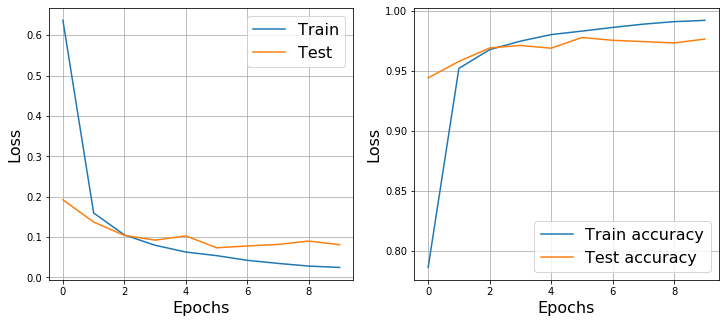

In [25]:
train(network_relu_fixed, 20, 0.05, True)

** Промежуточные выводы **  
Теоретически, ELU и ReLU лучше сигмоиды: они позволяют уменьшить затухание градиентов и увеличить зависимость последнего слоя от входных данных (избежать возрастания его коэффициентов), но на малых сетях это практически не заметно. ReLU и ELU с фиксированными параметрами дают лучшее качество как нелинейности для данных сетей

### Часть 2: Анализ ошибок

In [204]:
def ShowIncorrect(network):
    wrong_X = []
    correct_y = []
    predicted_y = []
    logits = []
    for X, y in test_loader:
        X = X.view(X.shape[0], -1).numpy()
        y = y.numpy()

        prediction = network.forward(X)
        prediction = np.exp(prediction)
        prediction /= prediction.sum(1, keepdims=True)
        for i in range(len(prediction)):
            if np.argmax(prediction[i]) != y[i]:
                wrong_X.append(X[i])
                correct_y.append(y[i])
                predicted_y.append(np.argmax(prediction[i]))
                logits.append(prediction[i][y[i]])

    wrong_X = np.row_stack(wrong_X)
    correct_y = np.row_stack(correct_y)[:, 0]
    predicted_y = np.row_stack(predicted_y)[:, 0]
    logits = np.row_stack(logits)[:, 0]
    
    plt.figure(figsize=(10, 5))
    order = np.argsort(logits)
    for i in range(21):
        plt.subplot(3, 7, i+1)
        plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
        plt.axis('off')

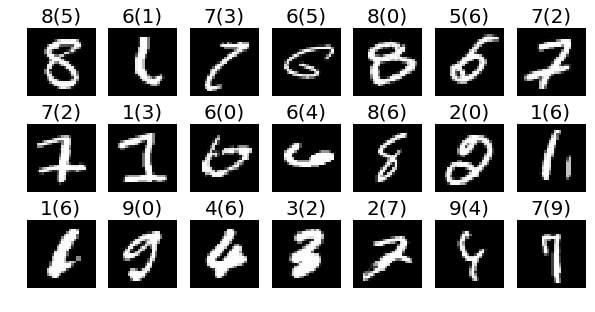

In [205]:
ShowIncorrect(network_sigmioid)

#### Влияние различных архитектур сетей

*Увеличение количества слоев*

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.95e-03; W_std = 9.97e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.92e-03; W_std = 9.92e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.ELU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.00e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.ReLU'> , coeff: 1.00e-01
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.96e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.63e-03 ; std: 9.38e-03
6 <class 'layers.Linear'> , mean (abs) grad: 2.37e-04 ; std: 2.96e-04
5 <class 'layers.ReLU'> , mean (abs) grad: 1.31e-04 ; std: 2.10e-04
4 <class 'layers.Linear'> , mean (abs) grad: 2.41e-05 ; std: 3.01e-05
3 <class 'layers.ELU'> , mean (abs) grad: 1.37e-05


Epoch 6... (Train/Test) NLL: 0.038/0.105	Accuracy: 0.987/0.971
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.20e-02; W_std = 4.94e-02 | b_mean (abs) = 2.09e-02; b_std = 1.88e-02
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.25e-02; W_std = 4.46e-02 | b_mean (abs) = 1.97e-02; b_std = 2.68e-02
3 <class 'layers.ELU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.70e-02; W_std = 2.38e-02 | b_mean (abs) = 3.03e-02; b_std = 3.95e-02
5 <class 'layers.ReLU'> , coeff: 1.00e-01
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.44e-02; W_std = 1.15e-01 | b_mean (abs) = 1.86e-01; b_std = 2.06e-01
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 1.84e-04 ; std: 1.81e-03
6 <class 'layers.Linear'> , mean (abs) grad: 1.16e-04 ; std: 7.78e-04
5 <class 'layers.ReLU'> , mean (abs) grad: 6.16e-05 ; std: 5.29e-04
4 <class 'layers.Linear'> , mean (abs) grad: 1.06e-04 ; 


Epoch 13... (Train/Test) NLL: 0.015/0.097	Accuracy: 0.995/0.978
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.97e-02; W_std = 6.12e-02 | b_mean (abs) = 2.69e-02; b_std = 2.35e-02
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.09e-02; W_std = 5.56e-02 | b_mean (abs) = 2.47e-02; b_std = 3.35e-02
3 <class 'layers.ELU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.96e-02; W_std = 2.77e-02 | b_mean (abs) = 3.45e-02; b_std = 4.69e-02
5 <class 'layers.ReLU'> , coeff: 1.00e-01
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 9.23e-02; W_std = 1.26e-01 | b_mean (abs) = 1.98e-01; b_std = 2.15e-01
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 3.06e-05 ; std: 3.79e-04
6 <class 'layers.Linear'> , mean (abs) grad: 2.24e-05 ; std: 1.65e-04
5 <class 'layers.ReLU'> , mean (abs) grad: 1.28e-05 ; std: 1.24e-04
4 <class 'layers.Linear'> , mean (abs) grad: 2.52e-05 ;

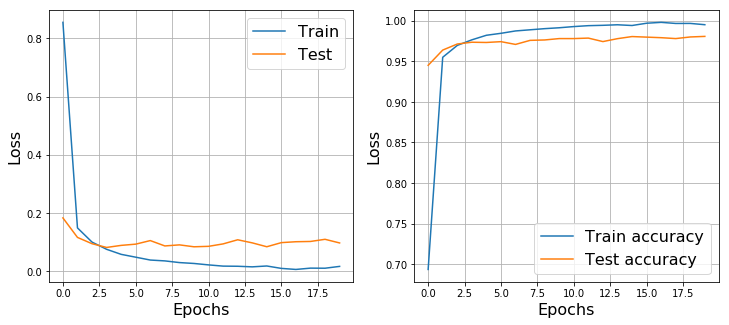

In [210]:
# Попробуем увеличить число слоев + 2 типа нелинейностей
network_mixed = NeuralNetwork([layers.Linear(784, 100), layers.ReLU(fixed=True),
                               layers.Linear(100, 300), layers.ELU(fixed=True, alpha0=0.1), 
                               layers.Linear(300, 200), layers.ReLU(fixed=True), layers.Linear(200, 10),
                               layers.SoftMax_NLLLoss()])
train(network_mixed, 20, 0.1, True)

* Простое увеличние количества слоев значительно не увеличивает качество. Вероятно, сеть переобучается

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.95e-03; W_std = 9.98e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.98e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.Sigmoid'> , coeff: No coeff
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.00e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.Sigmoid'> , coeff: No coeff
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.03e-03; W_std = 1.01e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.63e-03 ; std: 9.38e-03
6 <class 'layers.Linear'> , mean (abs) grad: 2.37e-04 ; std: 2.99e-04
5 <class 'layers.Sigmoid'> , mean (abs) grad: 5.92e-05 ; std: 7.45e-05
4 <class 'layers.Linear'> , mean (abs) grad: 8.26e-06 ; std: 1.04e-05
3 <class 'layers.Sigmoid'> , mean (ab


Epoch 6... (Train/Test) NLL: 1.401/1.333	Accuracy: 0.517/0.528
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.45e-02; W_std = 3.46e-02 | b_mean (abs) = 2.80e-02; b_std = 2.78e-02
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.57e-02; W_std = 4.53e-02 | b_mean (abs) = 2.98e-01; b_std = 1.35e-01
3 <class 'layers.Sigmoid'> , coeff: No coeff
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.08e-02; W_std = 2.10e-02 | b_mean (abs) = 2.50e-01; b_std = 1.03e-02
5 <class 'layers.Sigmoid'> , coeff: No coeff
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.26e-01; W_std = 2.77e-01 | b_mean (abs) = 3.71e+00; b_std = 4.56e+00
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 4.05e-03 ; std: 7.58e-03
6 <class 'layers.Linear'> , mean (abs) grad: 1.83e-03 ; std: 2.35e-03
5 <class 'layers.Sigmoid'> , mean (abs) grad: 1.25e-04 ; std: 1.89e-04
4 <class 'layers.Linear'> , mean (abs) grad


Epoch 13... (Train/Test) NLL: 0.389/0.346	Accuracy: 0.902/0.913
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.53e-02; W_std = 6.27e-02 | b_mean (abs) = 7.92e-02; b_std = 6.98e-02
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.24e-02; W_std = 8.52e-02 | b_mean (abs) = 4.68e-01; b_std = 3.22e-01
3 <class 'layers.Sigmoid'> , coeff: No coeff
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.19e-02; W_std = 6.13e-02 | b_mean (abs) = 3.79e-01; b_std = 3.20e-02
5 <class 'layers.Sigmoid'> , coeff: No coeff
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.32e-01; W_std = 4.38e-01 | b_mean (abs) = 5.25e+00; b_std = 6.45e+00
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 6.95e-04 ; std: 2.49e-03
6 <class 'layers.Linear'> , mean (abs) grad: 8.75e-04 ; std: 3.29e-03
5 <class 'layers.Sigmoid'> , mean (abs) grad: 7.82e-05 ; std: 3.63e-04
4 <class 'layers.Linear'> , mean (abs) gra


Epoch 20... (Train/Test) NLL: 0.099/0.164	Accuracy: 0.973/0.959
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 5.47e-02; W_std = 7.58e-02 | b_mean (abs) = 9.62e-02; b_std = 8.01e-02
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.00e-02; W_std = 1.00e-01 | b_mean (abs) = 4.86e-01; b_std = 3.37e-01
3 <class 'layers.Sigmoid'> , coeff: No coeff
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.77e-02; W_std = 7.27e-02 | b_mean (abs) = 3.83e-01; b_std = 4.58e-02
5 <class 'layers.Sigmoid'> , coeff: No coeff
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.58e-01; W_std = 4.92e-01 | b_mean (abs) = 5.21e+00; b_std = 6.61e+00
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 3.36e-04 ; std: 2.35e-03
6 <class 'layers.Linear'> , mean (abs) grad: 5.28e-04 ; std: 2.47e-03
5 <class 'layers.Sigmoid'> , mean (abs) grad: 8.38e-05 ; std: 5.05e-04
4 <class 'layers.Linear'> , mean (abs) gra


Epoch 27... (Train/Test) NLL: 0.049/0.161	Accuracy: 0.987/0.960
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 6.00e-02; W_std = 8.37e-02 | b_mean (abs) = 1.02e-01; b_std = 8.44e-02
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.46e-02; W_std = 1.08e-01 | b_mean (abs) = 5.03e-01; b_std = 3.56e-01
3 <class 'layers.Sigmoid'> , coeff: No coeff
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 5.07e-02; W_std = 7.88e-02 | b_mean (abs) = 3.88e-01; b_std = 4.83e-02
5 <class 'layers.Sigmoid'> , coeff: No coeff
6 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.73e-01; W_std = 5.21e-01 | b_mean (abs) = 5.24e+00; b_std = 6.71e+00
7 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

7 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 1.45e-04 ; std: 1.19e-03
6 <class 'layers.Linear'> , mean (abs) grad: 2.58e-04 ; std: 1.51e-03
5 <class 'layers.Sigmoid'> , mean (abs) grad: 3.87e-05 ; std: 3.03e-04
4 <class 'layers.Linear'> , mean (abs) gra

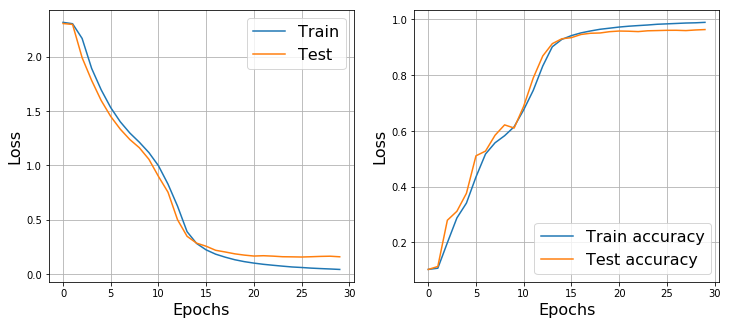

In [209]:
# Та же нейронная сеть на сигмоидах
network_mixed = NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(),
                               layers.Linear(100, 300), layers.Sigmoid(), 
                               layers.Linear(300, 200), layers.Sigmoid(), layers.Linear(200, 10),
                               layers.SoftMax_NLLLoss()])
train(network_mixed, 30, 0.1, True)

* Последний линейный слой слабо опирается на обучающую выборку, а имеет очень большие коэффициенты и предсказывает сам. Это следствие производной сигмоиды. Сигмоида вблизи 0 практически линейна, т.е. мы просто увеличиваем количество линейных коэффициентов => шума

*Уменьшение количества слоев*

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.98e-03; W_std = 1.00e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.90e-03; W_std = 9.93e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

3 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.62e-03 ; std: 9.37e-03
2 <class 'layers.Linear'> , mean (abs) grad: 2.30e-04 ; std: 2.89e-04
1 <class 'layers.Sigmoid'> , mean (abs) grad: 5.63e-05 ; std: 7.08e-05
0 <class 'layers.Linear'> , mean (abs) grad: 5.58e-06 ; std: 7.01e-06

Epoch 0... (Train/Test) NLL: 0.450/0.222	Accuracy: 0.870/0.936
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.93e-02; W_std = 2.77e-02 | b_mean (abs) = 8.05e-03; b_std = 9.95e-03
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.28e-01; W_std = 2.67e-01 | b_mean (abs) = 1.86e-02; b_std = 2.35e-02
3 <class 'layers.S


Epoch 11... (Train/Test) NLL: 0.045/0.077	Accuracy: 0.990/0.976
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.89e-02; W_std = 5.86e-02 | b_mean (abs) = 2.68e-02; b_std = 3.24e-02
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.66e-01; W_std = 5.63e-01 | b_mean (abs) = 5.36e-02; b_std = 6.29e-02
3 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

3 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 2.19e-04 ; std: 1.16e-03
2 <class 'layers.Linear'> , mean (abs) grad: 6.30e-04 ; std: 2.29e-03
1 <class 'layers.Sigmoid'> , mean (abs) grad: 4.38e-05 ; std: 2.51e-04
0 <class 'layers.Linear'> , mean (abs) grad: 5.71e-05 ; std: 2.39e-04

Epoch 12... (Train/Test) NLL: 0.041/0.075	Accuracy: 0.991/0.976
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.98e-02; W_std = 6.00e-02 | b_mean (abs) = 2.73e-02; b_std = 3.32e-02
1 <class 'layers.Sigmoid'> , coeff: No coeff
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.79e-01; W_std = 5.78e

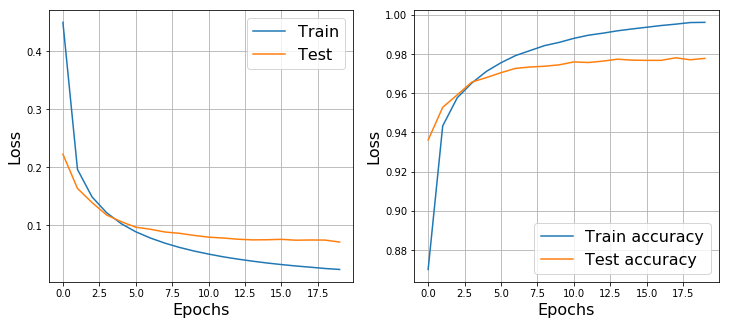

In [208]:
# Малая нейронная сеть
network_small = NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(),
                               layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
train(network_small, 20, 0.1, True)

* Малой нейронной сети просто не хватает коэффициентов для улучшения качества

** Промежуточные выводы **  
В нейронных сетях с большим количеством скрытых слоев несигмоидные нелинейности лучше. Малой нейронной сети просто не хватает коэффициентов для улучшения качества

### Часть 3: Предобработка данных

In [156]:
#Сеть - лучшая из обученных ранее
network_relu_fixed = NeuralNetwork([layers.Linear(784, 100), layers.ReLU(fixed=True), layers.Linear(100, 100), 
                                    layers.ReLU(fixed=True), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.96e-03; W_std = 9.97e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.06e-03; W_std = 1.01e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 8.02e-03; W_std = 1.01e-02 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.63e-03 ; std: 9.38e-03
4 <class 'layers.Linear'> , mean (abs) grad: 2.42e-04 ; std: 3.01e-04
3 <class 'layers.ReLU'> , mean (abs) grad: 1.25e-04 ; std: 2.02e-04
2 <class 'layers.Linear'> , mean (abs) grad: 1.61e-05 ; std: 2.05e-05
1 <class 'layers.ReLU'> , mean (abs) grad: 8.31e-06 ; std: 1.42e-05
0 <class 'layers.Linear'> , mean (abs) grad: 1.10e-06 ; std: 1.41e-06

Epoch 0... (Train/Test) NLL: 0.627/0.195	Accuracy: 0.793/0.942
0 <class '


Epoch 8... (Train/Test) NLL: 0.029/0.085	Accuracy: 0.991/0.976
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.44e-02; W_std = 3.67e-02 | b_mean (abs) = 1.29e-02; b_std = 1.51e-02
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.80e-02; W_std = 6.62e-02 | b_mean (abs) = 2.47e-02; b_std = 3.04e-02
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.43e-01; W_std = 1.88e-01 | b_mean (abs) = 1.08e-01; b_std = 1.34e-01
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 2.13e-05 ; std: 1.69e-04
4 <class 'layers.Linear'> , mean (abs) grad: 1.89e-05 ; std: 9.50e-05
3 <class 'layers.ReLU'> , mean (abs) grad: 1.16e-05 ; std: 6.86e-05
2 <class 'layers.Linear'> , mean (abs) grad: 2.82e-05 ; std: 1.23e-04
1 <class 'layers.ReLU'> , mean (abs) grad: 1.06e-05 ; std: 6.61e-05
0 <class 'layers.Linear'> , mean (abs) grad: 7.41e-06 ; std: 3.36e-05

Epoch 9..


Epoch 17... (Train/Test) NLL: 0.005/0.090	Accuracy: 0.999/0.980
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.88e-02; W_std = 4.36e-02 | b_mean (abs) = 1.56e-02; b_std = 1.80e-02
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 5.76e-02; W_std = 7.86e-02 | b_mean (abs) = 2.87e-02; b_std = 3.52e-02
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.67e-01; W_std = 2.19e-01 | b_mean (abs) = 1.10e-01; b_std = 1.37e-01
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.68e-07 ; std: 6.71e-06
4 <class 'layers.Linear'> , mean (abs) grad: 6.72e-07 ; std: 4.64e-06
3 <class 'layers.ReLU'> , mean (abs) grad: 4.13e-07 ; std: 3.58e-06
2 <class 'layers.Linear'> , mean (abs) grad: 1.19e-06 ; std: 8.29e-06
1 <class 'layers.ReLU'> , mean (abs) grad: 5.45e-07 ; std: 5.50e-06
0 <class 'layers.Linear'> , mean (abs) grad: 4.42e-07 ; std: 3.44e-06

Epoch 18

e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


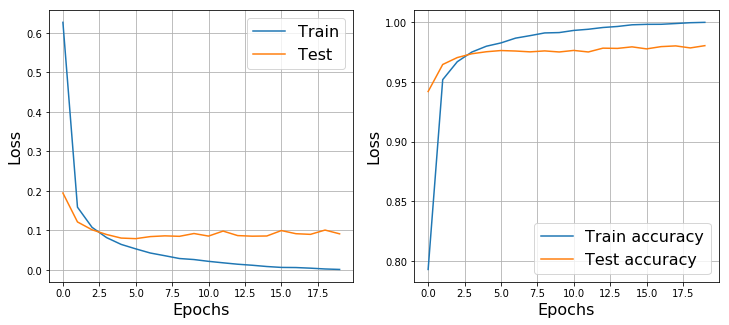

In [164]:
#Используем blur.
train(network_relu_fixed, 20, 0.05, verbose=True, blur=1.0, rad=5, central=3)

* Размытие только на обучающей выборке не улучшает результат. Попробуем также делать размытие на тесте

0 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.97e-03; W_std = 9.98e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.80e-03; W_std = 9.76e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 7.91e-03; W_std = 9.81e-03 | b_mean (abs) = 0.00e+00; b_std = 0.00e+00
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.62e-03 ; std: 9.37e-03
4 <class 'layers.Linear'> , mean (abs) grad: 2.38e-04 ; std: 2.96e-04
3 <class 'layers.ReLU'> , mean (abs) grad: 1.42e-04 ; std: 2.21e-04
2 <class 'layers.Linear'> , mean (abs) grad: 1.62e-05 ; std: 2.07e-05
1 <class 'layers.ReLU'> , mean (abs) grad: 8.98e-06 ; std: 1.48e-05
0 <class 'layers.Linear'> , mean (abs) grad: 1.18e-06 ; std: 1.49e-06

Epoch 0... (Train/Test) NLL: 0.610/0.199	Accuracy: 0.800/0.941
0 <class '


Epoch 8... (Train/Test) NLL: 0.031/0.082	Accuracy: 0.990/0.979
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 2.48e-02; W_std = 3.77e-02 | b_mean (abs) = 1.20e-02; b_std = 1.43e-02
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 4.85e-02; W_std = 6.64e-02 | b_mean (abs) = 2.55e-02; b_std = 3.15e-02
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.42e-01; W_std = 1.88e-01 | b_mean (abs) = 7.72e-02; b_std = 9.59e-02
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 7.27e-05 ; std: 7.60e-04
4 <class 'layers.Linear'> , mean (abs) grad: 5.97e-05 ; std: 4.19e-04
3 <class 'layers.ReLU'> , mean (abs) grad: 4.09e-05 ; std: 3.36e-04
2 <class 'layers.Linear'> , mean (abs) grad: 9.59e-05 ; std: 6.08e-04
1 <class 'layers.ReLU'> , mean (abs) grad: 4.11e-05 ; std: 3.58e-04
0 <class 'layers.Linear'> , mean (abs) grad: 2.64e-05 ; std: 1.84e-04

Epoch 9..


Epoch 17... (Train/Test) NLL: 0.006/0.097	Accuracy: 0.998/0.978
0 <class 'layers.Linear'> , coeff: W_mean (abs) = 3.00e-02; W_std = 4.57e-02 | b_mean (abs) = 1.50e-02; b_std = 1.70e-02
1 <class 'layers.ReLU'> , coeff: 1.00e-01
2 <class 'layers.Linear'> , coeff: W_mean (abs) = 5.91e-02; W_std = 8.07e-02 | b_mean (abs) = 3.11e-02; b_std = 3.86e-02
3 <class 'layers.ReLU'> , coeff: 1.00e-01
4 <class 'layers.Linear'> , coeff: W_mean (abs) = 1.65e-01; W_std = 2.17e-01 | b_mean (abs) = 7.86e-02; b_std = 9.70e-02
5 <class 'layers.SoftMax_NLLLoss'> , coeff: No coeff

5 <class 'layers.SoftMax_NLLLoss'> , mean (abs) grad: 5.00e-06 ; std: 5.73e-05
4 <class 'layers.Linear'> , mean (abs) grad: 6.51e-06 ; std: 4.34e-05
3 <class 'layers.ReLU'> , mean (abs) grad: 4.22e-06 ; std: 3.47e-05
2 <class 'layers.Linear'> , mean (abs) grad: 1.27e-05 ; std: 8.33e-05
1 <class 'layers.ReLU'> , mean (abs) grad: 5.21e-06 ; std: 4.64e-05
0 <class 'layers.Linear'> , mean (abs) grad: 3.50e-06 ; std: 2.72e-05

Epoch 18

e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


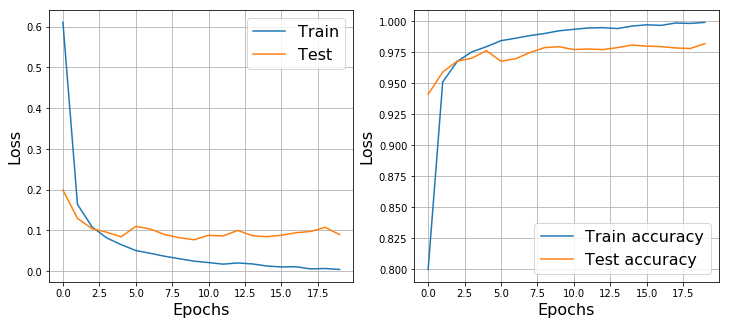

In [162]:
train(network_relu_fixed, 20, 0.05, verbose=True, blur=1.0, rad=5, central=3, blur_test=True)

* Случайное размытие на тесте улучшает качество (!)

In [215]:
#Добавим в датасет 2 поворота
def GetTransform(deg):
    if deg < 0:
        deg = 360.0+deg
    return transforms.Compose([transforms.RandomRotation(deg),
                               transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

transform0 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_with_transforms = ConcatDataset([MNIST('.', train=True, download=True, transform=transform0),
                                       MNIST('.', train=True, download=True, transform=GetTransform(3)),
                                       MNIST('.', train=True, download=True, transform=GetTransform(-3))])
train_loader_transforms = DataLoader(train_with_transforms, batch_size=4096, shuffle=True)


Epoch 0... (Train/Test) NLL: 2.227/1.813	Accuracy: 0.182/0.362

Epoch 1... (Train/Test) NLL: 1.554/0.819	Accuracy: 0.463/0.723

Epoch 2... (Train/Test) NLL: 1.001/0.496	Accuracy: 0.664/0.865

Epoch 3... (Train/Test) NLL: 0.834/0.380	Accuracy: 0.728/0.895

Epoch 4... (Train/Test) NLL: 0.719/0.390	Accuracy: 0.765/0.876

Epoch 5... (Train/Test) NLL: 0.652/0.326	Accuracy: 0.786/0.900

Epoch 6... (Train/Test) NLL: 0.593/0.454	Accuracy: 0.805/0.848

Epoch 7... (Train/Test) NLL: 0.533/0.235	Accuracy: 0.825/0.932

Epoch 8... (Train/Test) NLL: 0.482/0.202	Accuracy: 0.846/0.943

Epoch 9... (Train/Test) NLL: 0.462/0.279	Accuracy: 0.854/0.913

Epoch 10... (Train/Test) NLL: 0.438/0.168	Accuracy: 0.863/0.950

Epoch 11... (Train/Test) NLL: 0.378/0.161	Accuracy: 0.883/0.950

Epoch 12... (Train/Test) NLL: 0.358/0.151	Accuracy: 0.888/0.956

Epoch 13... (Train/Test) NLL: 0.323/0.144	Accuracy: 0.900/0.955

Epoch 14... (Train/Test) NLL: 0.350/0.229	Accuracy: 0.893/0.931

Epoch 15... (Train/Test) NLL: 0.30

e:\c_folders\users\fen\anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


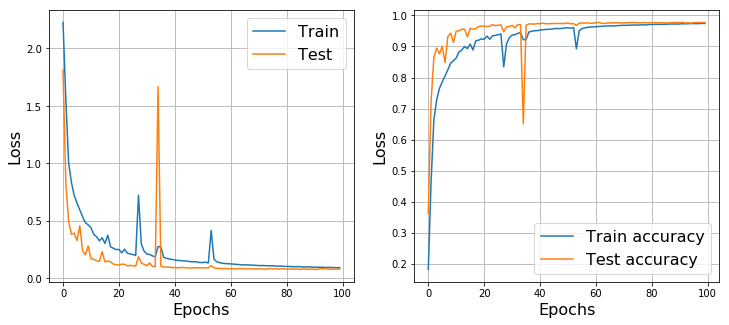

In [220]:
network_relu_fixed = NeuralNetwork([layers.Linear(784, 100), layers.ReLU(fixed=True), layers.Linear(100, 100), 
                                    layers.ReLU(fixed=True), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
train(network_relu_fixed, 100, 0.3, verbose=False, train=train_loader_transforms, blur=1.0, rad=5, central=3, blur_test=True)

* Повороты не улучшают качество сходимости

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

1. Теоретически, ELU и ReLU лучше сигмоиды: они позволяют уменьшить затухание градиентов и увеличить зависимость последнего слоя от входных данных (избежать возрастания его коэффициентов), но на малых сетях это практически не заметно.
2. Однако уже на нейронных сетях среднего размера использование сигмоиды приводит к увеличению коэффициентов последних слоев вероятно как за счет затухания градиентов, так и (без специальной инициализации) за счет близости сигмоиды к линейной функции вблизи 0
3. Простое увеличение количества слоев не приводит к прямому повышению качества (вероятно, из-за переобучения сети). Снижение количества слоев также не увеличивает качества
4. Использование аугментации улучшает качество классификации, но требуемый тип аугментации зависит от специфики выборки